# Let the challenge begin

**Notes on data** 

- 5 EEG derivations sampled at 250Hz
- 3 Accelerometers derivations sampled at 50Hz
- Sleep epoch = 30 sec
- hypnogram = succession of the sleep stages (0...5)

**General info sleep**
- Sleep stages = (N1, N2) = light sleep, N3 = deep sleep, REM
- Low frequency power: N3 > N2 > N1-REM-Wake

**Wake**
- During Wake epoch alpha waves are clearly visible on the F-O derivation
- Movement occured mainly during wake periods, noisy signals during movement
- Alpha wave frequency ranges between 8 and 13 hertz = wake, relaxed
**N1**
- Theta waves freq betw 4 and 8 Hz = N1, N2

**N2**
- On N2 epoch, power in the spindle range is much higher on frontal-frontal channels
- Theta waves freq betw 4 and 8 Hz = N1, N2
- During N2, sleep spindles (fast rythm between 12-14Hz which last between 0.5 up to 2 seconds) are more visible on the Frontal-frontal derivation

**N3**
- On N3 epoch, we can see more power in the low frequencies
- Delta waves freq betw 1 and 4 Hz = N3

**REM**
- REM sleep distinguishable with steady EEG and eyes movement which can be seen when looking at Frontal-occipital vs frontal-frontal derivation.
- The EEG power increases in the low-frequency band when the sleep stage change from REM to NREM sleep stages
- REM epoch have more steady EEG

**Formulas**
- Spectrogram are the time-frequency matrix z = P(t, f)
- Spectrum correspond to the curves y = P(frequency)
- Average Spectrum can therefore be computed as the mean of spectromgram over a specified period 

**Links**
https://opentext.wsu.edu/psych105/chapter/stages-of-sleep/
https://www.sleepfoundation.org/how-sleep-works/alpha-waves-and-sleep
https://centralesupelec.edunao.com/pluginfile.php/242107/course/section/36663/Challenge%20Data%20Dreem-1.pdf
https://centralesupelec.edunao.com/pluginfile.php/242107/course/section/36663/entropy-18-00272.pdf



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import json
import yasa
import os
import numpy as np
import pandas as pd
from scipy.signal import iirfilter, filtfilt
from scipy.signal import welch
from lspopt import spectrogram_lspopt
from scipy.signal import spectrogram
from os import listdir
from random import randint
import random as rd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier

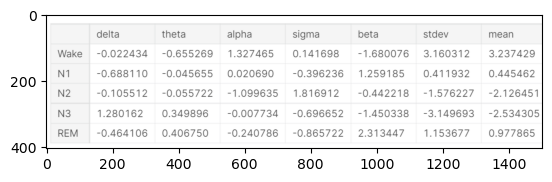

In [5]:
plt.imshow(plt.imread('corr_sleep_stages.png'))

In [6]:
eeg = np.load('sample/sample/f7_O2.npy') 
print('EEG duration', eeg.shape[0] / 250)
accelerometer_x = np.load('sample/sample/accelerometer_x.npy') 
print('Accelerometer duration', accelerometer_x.shape[0] / 50)
hypnogram = np.array(json.load(open('sample/sample/hypnogram.json')))
eeg = np.load('sample/sample/f7_O2.npy')
eeg_frontal = np.load('sample/sample/f8_f7.npy')
accelerometer_x = np.load('sample/sample/accelerometer_x.npy')


EEG duration 25845.94
Accelerometer duration 25845.94


In [7]:
def get_average_spectrum_for_epochs(eeg,epochs):
    """
    Return the average power in each of the fourier bin for several epochs.
    """
    EEG_FS = 250
    psds = []
    for epoch in epochs:
        idx_start,idx_end = 250 * 30 * epoch,250 * 30 * (epoch + 1)
        freqs,t,psd = spectrogram_lspopt(np.clip(eeg[idx_start:idx_end],-150,150),250,nperseg = 1000)
        psds += [np.mean(psd ** 2,1)]
    return freqs,np.array(psds).mean(0)

In [8]:
# predictions = []
# true_labels = hypnogram

# # Get your scores
# scores = {}
# scores['balanced_accuracy'] = balanced_accuracy_score(true_labels, predictions)
# scores['cohen_kappa'] = cohen_kappa_score(true_labels, predictions)
# scores['confusion_matrix'] = confusion_matrix(true_labels, predictions)

# print(scores)

In [9]:
## Function to plot N sleep epochs for a specific stage 

freq = 250 
epoch_s = 30

def random_sleep_epoch(N, sleep_stage) :
    k = 0
    a = randint(0,len(hypnogram))
    epochs = []
    while k < N:
        if hypnogram[a] == sleep_stage :
            epochs.append(a)
            k += 1
            a = randint(0,len(hypnogram))
        else :
            a = randint(0,len(hypnogram))
    eeg_ff = np.load('sample/sample/f8_f7.npy')
    for epoch in epochs : 
        t0 = epoch*epoch_s*freq
        eeg_short = eeg_ff[t0:t0+(epoch_s*freq)]
        plt.figure(figsize=(25, 8))
        plt.plot(eeg_short)
        plt.ylim([-200, 200])
        plt.xlim(0,len(eeg_short))
        plt.show()

2: Machine learning models

In [10]:
frequency_bands = {
        "delta": [0.5, 4],
        "theta": [4, 8],
        "alpha": [8, 12],
       "sigma": [12, 16],
       "beta": [16, 30]
    }

EEG_FS = 250
ACC_FS = 50 
epoch_s = 30
n_EEG = 5
n_ACC = 3

In [11]:
def get_relative_spectral_power_for_epoch(data):
    """
    Compute the relative spectral power for each of the frequency bands defined above
    """
    EEG_FS = 250
    psds = []
    sfreqs,t,psd = spectrogram(data,250,nperseg = 1000,noverlap = 750)
    psd = np.mean(np.abs(psd),-1)
    spectral_power_band = {}
    for name, freqband in frequency_bands.items():
        spec_power = psd[:,(sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
        spec_power = np.sum(spec_power, 1)
        spectral_power_band[name] = spec_power / np.sum(psd,1)
        
    return spectral_power_band

In [12]:
statistics = {
    "stdev":lambda x:np.std(x,1),
    "mean":lambda x:np.mean(np.abs(x),1)
}
variable_lists = list(frequency_bands) + list(statistics)

In [13]:
def compute_stats(data):
    """
    Compute the statistics of a signal
    """
    EEG_FS = 250
    result = {k:f(data) for k,f in statistics.items()}
    return result


In [12]:
pippo = np.load('./training_records/record_1.npy')
np.shape(pippo)


(806, 42001)

In [115]:
data_for_records_all = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')
for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    EEG = x[:,1:EEG_FS * epoch_s * n_EEG + 1]
    ACC = x[:,EEG_FS * epoch_s * n_EEG + 1:]
    EEG = EEG.reshape(len(x), n_EEG, EEG_FS * epoch_s)
    ACC = ACC.reshape(len(x), n_ACC, ACC_FS * epoch_s)

    for i in range (n_EEG) :
        sfreqs,t,psd = spectrogram(EEG[:,i,:], EEG_FS, nperseg = 1000,noverlap = 750)
        psd = np.mean(np.abs(psd),-1)
        spectral_power_band = []
        l = []
        for name, freqband in frequency_bands.items():
            spec_power = psd[:,(sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
            spec_power = np.sum(spec_power, 1)
            l.append(spec_power / np.sum(psd,1))
        matrice = np.array(l) 
        matrice = np.vstack((matrice, np.array([np.mean(EEG[k,i,:]) for k in range (len(EEG))]).T))
        matrice = np.vstack((matrice, np.array([np.std(EEG[k,i,:]) for k in range (len(EEG))]).T))

        if i == 0:
            complete_array = matrice 
        else :
            complete_array = np.vstack((complete_array,matrice))
    
    for i in range (n_ACC) : 
        sfreqs,t,psd = spectrogram(ACC[:,i,:], ACC_FS, nperseg = 1000,noverlap = 750)
        psd = np.mean(np.abs(psd),-1)
        spectral_power_band = []
        l = []
        for name, freqband in frequency_bands.items():
            spec_power = psd[:,(sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
            spec_power = np.sum(spec_power, 1)
            l.append(spec_power / np.sum(psd,1))
        matrice = np.array(l)
        matrice = np.vstack((matrice, np.array([np.mean(ACC[k,i,:]) for k in range (len(ACC))]).T))
        matrice = np.vstack((matrice, np.array([np.std(ACC[k,i,:]) for k in range (len(ACC))]).T))
        complete_array = np.vstack((complete_array, matrice))
    data_for_records_all[record] = complete_array.T
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])
    
variable_lists = (list(frequency_bands) + list(statistics)) 

In [116]:
variable_list = []
stats = 'mean', 'std'
for n in range (n_EEG) :
    for freq in list(frequency_bands) : 
        variable_list.append(f"EEG_{n+1}_{freq}")
    for stat in stats :
        variable_list.append(f"EEG_{n+1}_{stat}")
for n in range (n_ACC) : 
    for freq in list(frequency_bands) : 
        variable_list.append(f"ACC_{n+1}_{freq}")
    for stat in stats :
        variable_list.append(f"ACC_{n+1}_{stat}")

In [117]:
print(len(variable_list))
print(len(data_for_records_all['record_0.npy'][0]))

56
56


In [118]:
def correlations(record, data, n) :
    corr = [0]*n
    for i in range (n) :
        corr[i] = [0]*n
        for j in range (n) :
            corr[i][j] = np.corrcoef(data[record,i,:], data[record,j,:])[0][1]
    return corr 

# EEG
corr = correlations(0, EEG, n_EEG)
for i in range (n_EEG) :
    print(i+1,corr[i])

# ACC
corr = correlations(0, ACC, n_ACC)
for i in range (n_ACC) :
    print(i+1,corr[i])


1 [1.0, 0.5660822760927271, 0.013936984473572308, 0.9509092151099715, 0.4851370689507625]
2 [0.5660822760927271, 1.0, 0.14547300930771026, 0.5808749587606346, 0.7806696749861819]
3 [0.013936984473572308, 0.14547300930771023, 1.0, 0.3226927235502929, -0.5047295022559589]
4 [0.9509092151099715, 0.5808749587606346, 0.3226927235502929, 1.0, 0.30301487317151954]
5 [0.4851370689507625, 0.7806696749861818, -0.5047295022559589, 0.3030148731715196, 1.0]
1 [1.0, 0.9852172307697551, 0.9530669703030024]
2 [0.985217230769755, 1.0, 0.9616551356898637]
3 [0.9530669703030024, 0.9616551356898637, 1.0]


TODO: 
- include all EEG / accelerometer? channels
    - for EEG: do spectral analysis for each channel
    - think about what to do with accelerometer channels 

change variable names

https://github.com/Kaggle/kaggle-api

In [144]:
# Create train and cross-validation partitions
rd.seed(2134)
records_list = list(data_for_records_all)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]

print('Training records: ',training_record)
print('Test records: ', test_records)

Training records:  ['record_5.npy', 'record_0.npy', 'record_1.npy', 'record_6.npy']
Test records:  ['record_4.npy', 'record_2.npy', 'record_3.npy']


VERY LATER: take training data and test data already cut  / for now keep this division

In [145]:
def build_dataset(records, data_for_records_all,hypnogram_for_records):
    X,y = [],[]
    for record in records : 
        y.extend(hypnogram_for_records[record])
        X.extend(data_for_records_all[record])
    return X,y

X_train,y_train = build_dataset(training_record,data_for_records_all,hypnogram_for_records)
X_test,y_test = build_dataset(test_records,data_for_records_all,hypnogram_for_records)

In [121]:
print(len(X_train), len(y_train))

3373 3373


# Random forest classifier

training...
{'balanced_accuracy': 0.535669545649308, 'cohen_kappa': 0.5792482922064162, 'macro_f1': 0.5427114973742679}


c:\Users\melin\mne-python\1.2.1_0\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


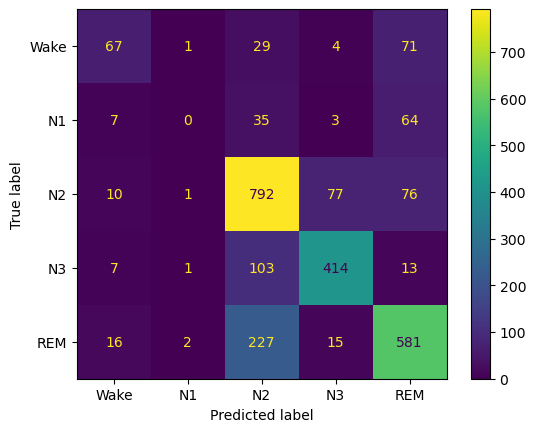

In [146]:
# run decision tree
clf_rf = RandomForestClassifier(random_state=42)
print('training...')
clf_rf.fit(X_train, y_train)

# test it
predictions = clf_rf.predict(X_test)
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
plot_confusion_matrix(clf_rf, X_test,y_test,display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

In [ ]:
# import sklearn

# metrics = "balanced_accuracy","f1_macro"

# sklearn.model_selection.cross_validate(clf_rf, X_train, y_train, scoring=metrics)

# clf_rf

### Evaluate importance of each parameter: Permutation importance

permutations...


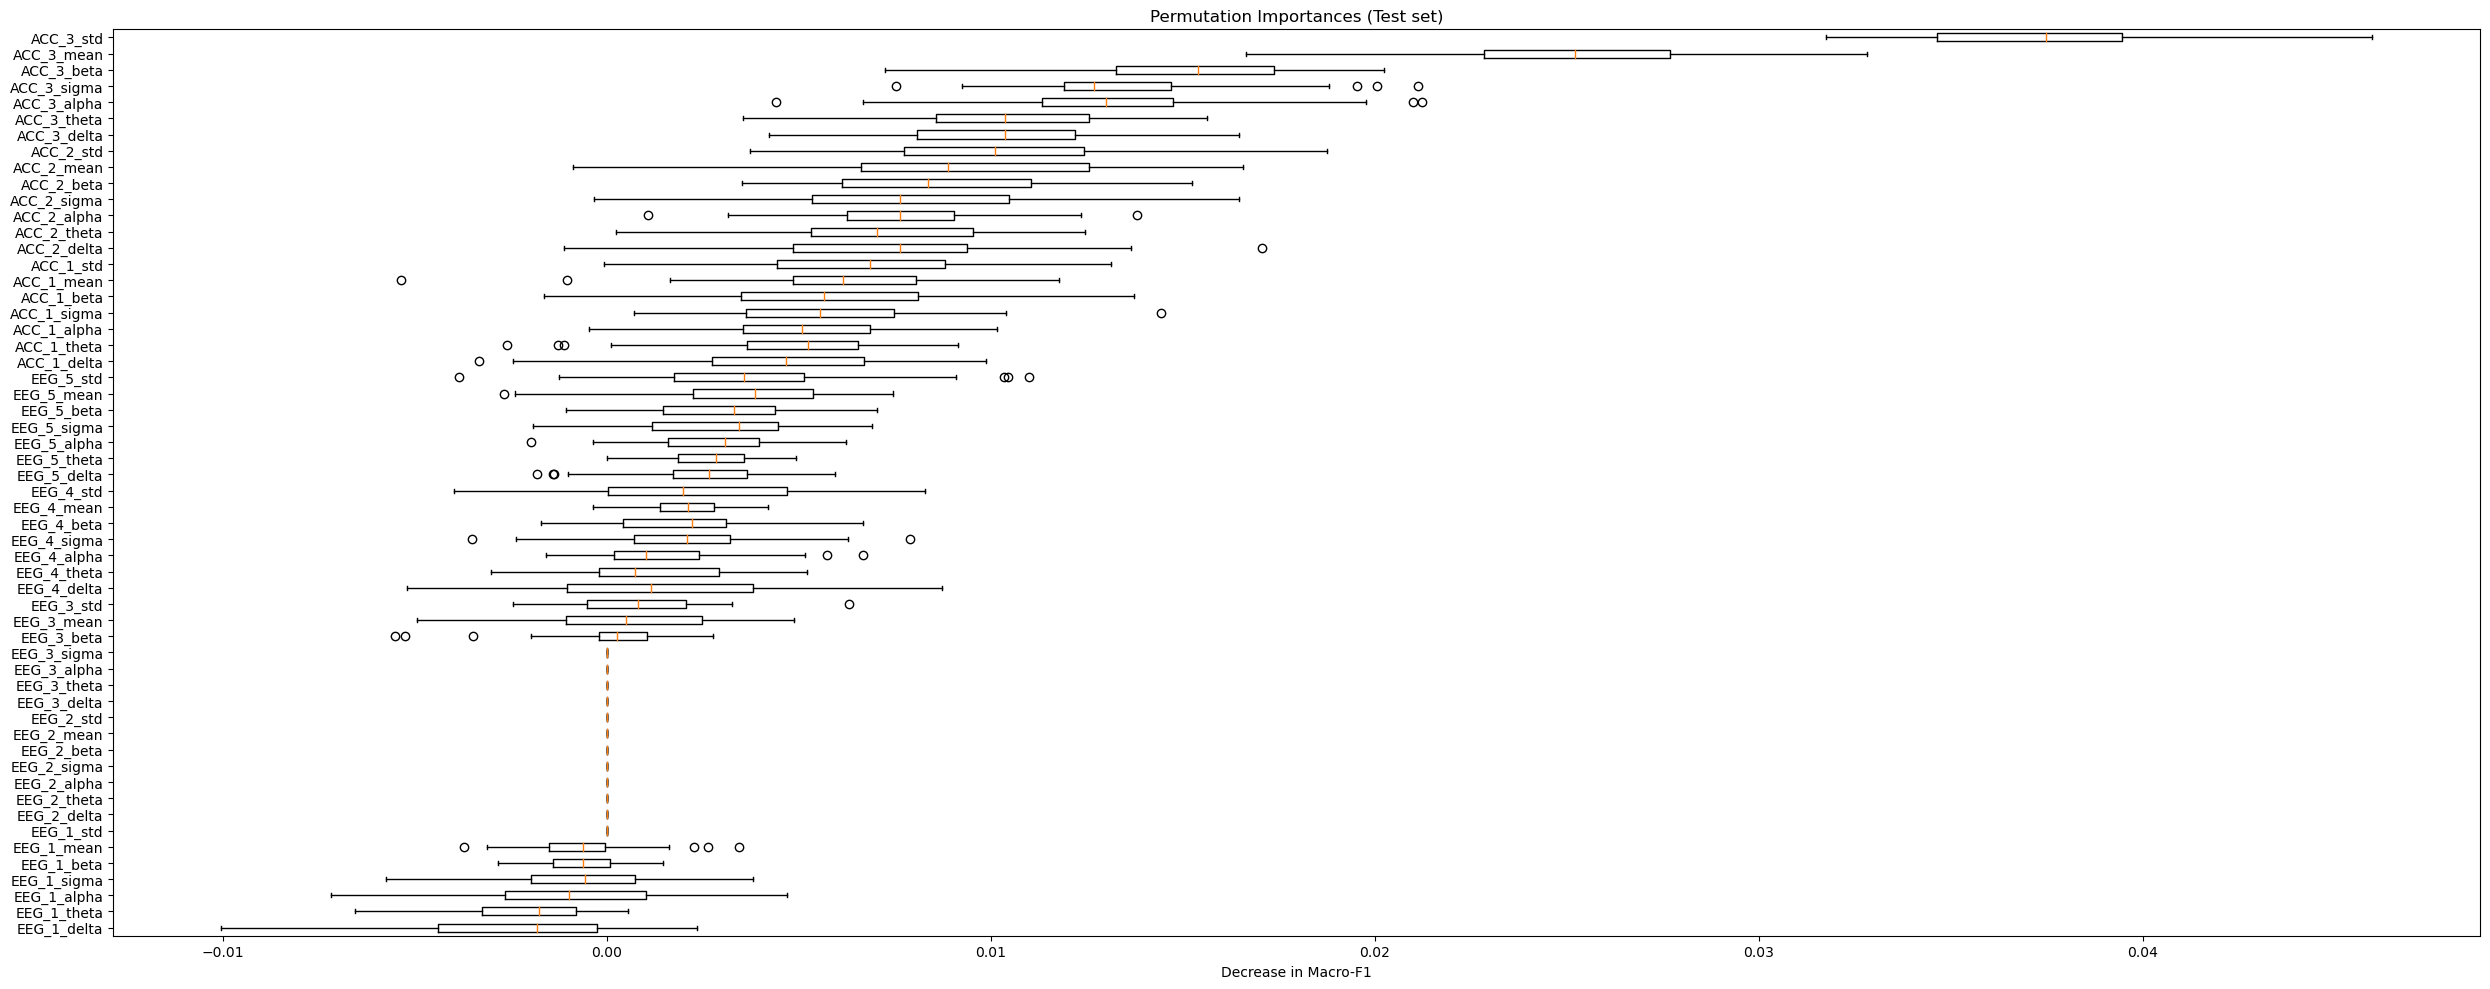

In [123]:
print('permutations...')
from sklearn.inspection import permutation_importance
# We use the build-in sklearn fontion to compute the permutation importance
result = permutation_importance(clf_rf, X_test, y_test, n_repeats=50, random_state=0,scoring = 'f1_macro')
sorted_idx = result.importances_mean.argsort()

# And plot the importance of each variable
fig, ax = plt.subplots(figsize=(25, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=variable_list)
ax.set_title("Permutation Importances (Test set)")
plt.xlabel('Decrease in Macro-F1')
fig.tight_layout()
plt.show()

In [147]:
f1 = []
for k in range (len(variable_list)) : 
    X_train_k = X_train.copy()
    X_train_k = np.delete(X_train_k, k, 1)
    X_test_k = X_test.copy()
    X_test_k = np.delete(X_test_k, k, 1)
    clf_rf.fit(X_train_k, y_train)
    predictions = clf_rf.predict(X_test_k)
    f1.append(f1_score(y_test, predictions,average ='macro'))


[12 29 26 19 15 35  0 55 16 38 39 37  1 30 41 11 28 34 54 13 36  2 47 50
 51 52 53 32 49 48 20 17 25 10 18  6  3  8 23 31 27  9 40  7 33 43 44 45
 46  5  4 14 42 24 21 22]
[0.5436717323496487, 0.5535081719211243, 0.5595715701188202, 0.5599820579275535, 0.5621753911280969, 0.5644868385559041, 0.5658765072520839, 0.5669822149225262, 0.5673042044536623, 0.5673623566694094, 0.5673623566694094, 0.5673623566694094, 0.5678191481839002, 0.5711443487661189, 0.5748924329061543, 0.5749010016678866, 0.5750593094003568, 0.5775946927090121, 0.5797223695588707, 0.5801110320190929, 0.5803488409229344, 0.5803658584025083, 0.5816689750237609, 0.5817528619213426, 0.5817528619213426, 0.5817528619213426, 0.5817528619213426, 0.5822210047927159, 0.5825795151516872, 0.5833308402338881, 0.5837442335254942, 0.5840864265311909, 0.5849840069715839, 0.5853885537784935, 0.5857460863851529, 0.5860585675511621, 0.5861209825920185, 0.5869269447119293, 0.5869550772955945, 0.5872155264372015, 0.5873338357687499, 0.58841

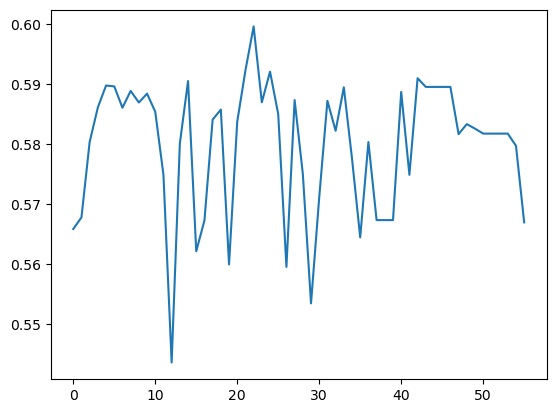

In [139]:
plt.plot(f1)
f1_order = np.argsort(np.array(f1))
f1_sorted = [f1[i] for i in f1_order]
print(f1_order)
print(f1_sorted)
variables_sorted = [variable_list[i] for i in f1_order]
print(variables_sorted)

[26 49  5 40 36 41 20 55 39 38 37 14  3  1 51 52 53 50 42 29 27 28  2 47
 23 17 16 18 34 24 25  4  0  8 21 15 33 54 12 22 32 45 43 44 46 19 31 11
 10 35  7 13 30 48  9  6]
[0.5285921706943215, 0.5300096777074107, 0.5305122387547246, 0.5326006565011034, 0.5330775447561711, 0.5351436502240882, 0.5354207713416617, 0.535881175716298, 0.5362660257336357, 0.5362660257336357, 0.5362660257336357, 0.5365394444017312, 0.537642815487972, 0.5378889676417862, 0.5385165807062553, 0.5385165807062553, 0.5385165807062553, 0.5385165807062553, 0.53926710278394, 0.5397162363625225, 0.5406600255834119, 0.5410581484304252, 0.5418401563392725, 0.541858885732051, 0.5429267675177015, 0.5433491476538673, 0.5438352494558976, 0.5439164701212065, 0.5441100800154234, 0.5455989243030486, 0.5457190137937411, 0.5464575558813374, 0.5464901958596855, 0.5466703467361007, 0.5468630976001012, 0.546966065620021, 0.5472270936286554, 0.5474604324602524, 0.5475154550770156, 0.5476801899117681, 0.548058052484414, 0.548078734146

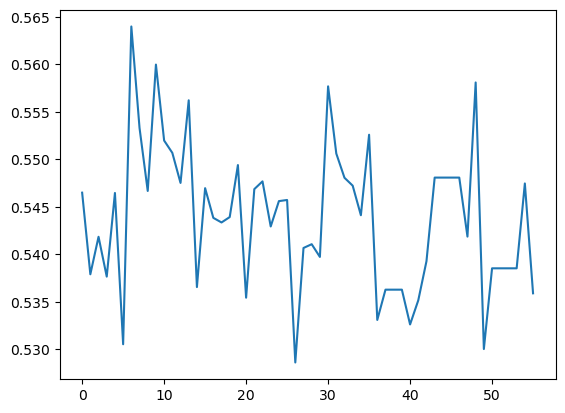

In [148]:
plt.plot(f1)
f1_order = np.argsort(np.array(f1))
f1_sorted = [f1[i] for i in f1_order]
print(f1_order)
print(f1_sorted)
variables_sorted = [variable_list[i] for i in f1_order]
print(variables_sorted)

Spectral components have a very marginal effect on classification -> to be improved

Todo: implement cross validation and compare with no cross validation
check if CV useful with random 
MAJOR CHANGE

TODO: plot test error for CV/test set

## Deep learning

### (temporary) load single record data

In [19]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')
for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_records[record] = x[:,1:250 * 30 + 1]
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

In [21]:
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:5],records_list[5:]

print('Training records: ',training_record)
print('Test records: ', test_records)

Training records:  ['record_1.npy', 'record_2.npy', 'record_5.npy', 'record_4.npy', 'record_0.npy']
Test records:  ['record_3.npy', 'record_6.npy']


In [22]:
def build_dataset(records, data_for_records,hypnogram_for_records):
    X,y = [],[]
    for record in records:
        X.append(data_for_records[record])
        y.extend(hypnogram_for_records[record])

    return np.concatenate(X),y


X_train,y_train = build_dataset(training_record,data_for_records,hypnogram_for_records)
X_test,y_test = build_dataset(test_records,data_for_records,hypnogram_for_records)



In [27]:
""" Load project data
    DataLoader and Dataset for single-channel EEG

"""

import torch
from torch.utils.data import Dataset, DataLoader


def normalize_data(eeg_array):
    """normalize signal between 0 and 1"""

    normalized_array = np.clip(eeg_array, -250, 250)
    normalized_array = normalized_array / 250

    return normalized_array


class EegEpochDataset(Dataset):
    """EEG Epochs dataset."""

    def __init__(self, x_data, y_data, transform=None):
        """
        Args:
            x_data (numpy array): Numpy array of input data.
            y_data (list of numpy array): Sleep Stages
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.y_data = y_data
        self.x_data = x_data
        self.transform = transform

        self.x_data = normalize_data(x_data)

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        signal = np.expand_dims(self.x_data[idx], axis=0)
        stage = self.y_data[idx]

        if self.transform:
            signal = self.transform(signal)

        return signal, stage


training_dataset = EegEpochDataset(X_train,y_train)
training_dataloader = DataLoader(training_dataset,batch_size = 32)
validation_dataset = EegEpochDataset(X_test,y_test)
validation_dataloader = DataLoader(validation_dataset,batch_size = 32)


OSError: [WinError 182] Le système d’exploitation ne peut pas exécuter %1. Error loading "c:\Users\melin\mne-python\1.2.1_0\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [ ]:
import torch.nn as nn


class SingleChannelConvNet(nn.Module):

    def __init__(self):
        super(SingleChannelConvNet, self).__init__()
        self.conv_a = nn.Conv1d(1, 8, 25, stride=5)
        self.conv_b = nn.Conv1d(8, 16, 10, stride=5)
        self.conv_c = nn.Conv1d(16, 32, 10, stride=5)
        self.conv_d = nn.Conv1d(32, 64, 10, stride=5)

        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64, 5)

    def forward(self, x):

        x = self.relu(self.conv_a(x))
        x = self.relu(self.conv_b(x))
        x = self.relu(self.conv_c(x))
        x = self.relu(self.conv_d(x))
        x = x.max(-1)[0]
        x = self.fc1(x)

        return x
